In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [8]:
glm = 1
dir_glm = su.get_dir_glm(glm)

In [9]:
list_sn = su.get_list_sn()

---

In [10]:
dir_work = join(su.get_dir_surf(),'glm_%d'%glm)
dir_work

'/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1'

In [11]:
list_roi = simage.get_list_roi()

In [12]:
border, brdr = simage.get_border(join(dir_git,'surfAnalysisPy'))
hem = 'L'

---

In [13]:
subj = 'S01'

In [14]:
reginfo = deal_spm.load_reginfo(subj,dir_glm)
reginfo

,sn,run,cond,regIdx,seq,cue,reg
0,1,1,1,1,1,L,"(1,L)"
1,1,1,2,2,1,S,"(1,S)"
2,1,1,3,3,2,L,"(2,L)"
3,1,1,4,4,2,S,"(2,S)"
4,1,1,5,5,3,L,"(3,L)"
...,...,...,...,...,...,...,...
59,1,8,4,60,2,S,"(2,S)"
60,1,8,5,61,3,L,"(3,L)"
61,1,8,6,62,3,S,"(3,S)"
62,1,8,7,63,4,L,"(4,L)"


In [15]:
def get_df_idx(subj, glm):
    reginfo = deal_spm.load_reginfo(subj,dir_glm)
    df_idx = pd.DataFrame()
    df_idx['letter'] = reginfo.cue.str.contains('L', case=False).values
    df_idx['spatial'] = reginfo.cue.str.contains('S', case=False).values
    for seq in np.arange(1,5):
        df_idx['seq%d'%seq] = reginfo.seq.astype(str).str.contains('%d'%seq, case=False).values
    
    return df_idx

In [16]:
df_idx = get_df_idx(subj=subj, glm=glm)
df_idx

,letter,spatial,seq1,seq2,seq3,seq4
0,True,False,True,False,False,False
1,False,True,True,False,False,False
2,True,False,False,True,False,False
3,False,True,False,True,False,False
4,True,False,False,False,True,False
...,...,...,...,...,...,...
59,False,True,False,True,False,False
60,True,False,False,False,True,False
61,False,True,False,False,True,False
62,True,False,False,False,False,True


### i) Calculate Contrast

In [17]:
dataset = {}
for ii, nn in enumerate(tqdm(list_sn)):
    subj = 'S'+nn

    ## ============ beta =========== ##
    # ## index
    # df_idx = get_df_idx(subj=subj, glm=glm)

    # ## load ResMS
    # fname = join(dir_work,subj,'%s.%s.glm_%d.ResMS.func.gii'%(subj,hem,glm))
    # darray = nb.load(fname).darrays
    # ResMS = darray[0].data
    # del darray
    
    # ## load beta
    # sss = 'beta_mean'
    # fname = join(dir_work,subj,'%s.%s.glm_%d.beta.func.gii'%(subj,hem,glm))
    # darrays = nb.load(fname).darrays
    # data = np.ones((len(df_idx),32492)) * np.nan
    # for jj, darray in enumerate(darrays):
    #     data[jj] = darray.data
    # del darrays
    # ## ============================= ##
    # ## contrast
    # for cue in ['letter','spatial']:
    #     if ii==0:
    #         dataset[cue] = np.ones((len(list_sn),32492)) * np.nan
    #     idx_cue = df_idx[cue].values.astype(int)
    #     ## cue
    #     contrast = idx_cue
    #     dataset[cue][ii,:] = contrast@data
    # del data

    ## ============ spmT =========== ##
    ## load spmT
    sss = 'spmT'
    fname = join(dir_work,subj,'%s.%s.glm_%d.t.func.gii'%(subj,hem,glm))
    darrays = nb.load(fname).darrays
    t_order = np.genfromtxt(
        join(dir_work,subj,'%s.t_orders.csv'%subj),
        delimiter='\t', dtype=None, encoding='utf-8'
    )
    data = np.ones((len(t_order),32492)) * np.nan
    for jj, darray in enumerate(darrays):
        tmap = darray.data
        data[jj] = tmap
    del darrays, darray

    for jj, name in enumerate(t_order):
        cond = name.split('.')[0].replace('spmT_','').replace('_L','_letter').replace('_S','_spatial').replace('Letter','letter').replace('Spatial','spatial')
        if ii==0:
            dataset[cond] = np.ones((len(list_sn),32492))
        dataset[cond][ii,:] = data[jj]
    ## ============================= ##

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.97it/s]


### Save the dataset as cifti

In [18]:
dir_output = join(su.get_dir_surf(),'glm_%d'%glm)
for key, value in dataset.items():
    bm_axis = nb.cifti2.BrainModelAxis.from_surface(vertices=np.arange(32492), nvertex=32492, name='CortexLeft')
    scalar_axis = nb.cifti2.ScalarAxis(list_sn)
    header = nb.Cifti2Header.from_axes((scalar_axis, bm_axis))
    
    cii = nb.Cifti2Image(dataobj=value, header=header)
    nb.save(cii, join(dir_output,'cifti.%s.glm_%1d.%s.%s.dscalar.nii'%(hem,glm,sss,key)))

### ii) Load the dataset from cifti

In [19]:
glob(join(dir_work,'*.nii'))

['/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.beta_mean.letter.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.beta_mean.spatial.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.spmT.(1,L).dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.spmT.(1,S).dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.spmT.(2,L).dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.spmT.(2,S).dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.spmT.(3,L).dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.spmT.(3,S).dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/surfaceWB/glm_1/cifti.L.glm_1.spmT.(4,L).dscalar.nii',
 '/Vol

In [20]:
dataset = {}
for cond in ['letter','spatial']:
    ## ============ beta =========== ##
    # fname = join(dir_work, 'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,cond))
    # dataset[cond] = nb.load(fname).get_fdata()
    ## ============ spmT =========== ##
    fname = join(dir_work, 'smooth.cifti.%s.glm_%1d.spmT.%s.dscalar.nii'%(hem,glm,cond))
    dataset[cond] = nb.load(fname).get_fdata()

## 1. Letter vs. Spatial

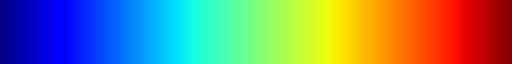

In [21]:
cmap = cm.jet
cmap

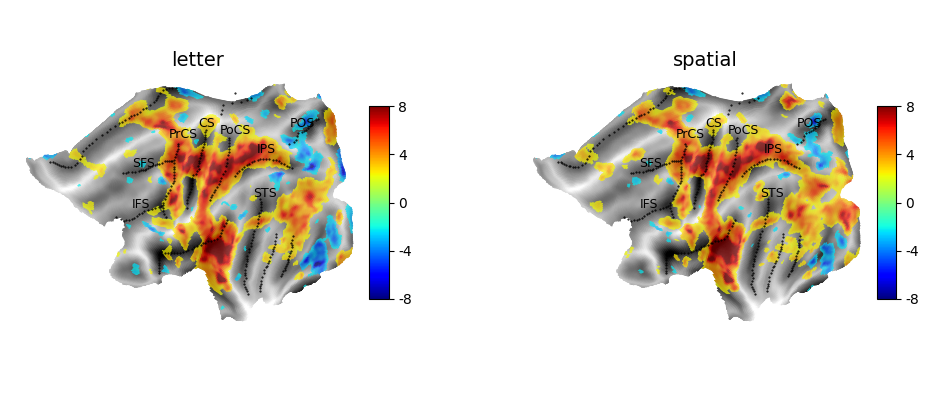

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

for ii, sss in enumerate(['letter','spatial']):
    ax=axs[ii]
    plt.sca(ax)
    res = scipy.stats.ttest_1samp(dataset[sss], popmean=0, axis=0)
    thresh = su.convert_alpha_to_tval(alpha=0.05, df=res.df.mean())
    data = res.statistic
    # data = scipy.ndimage.gaussian_filter(data, sigma=0.6)
    color = 'black'
    g = surf.plot.plotmap(
        data=data,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-8,8],
        threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=1,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=sss, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

## 2. Zoom-in

In [23]:
vmin, vmax = -10, 10

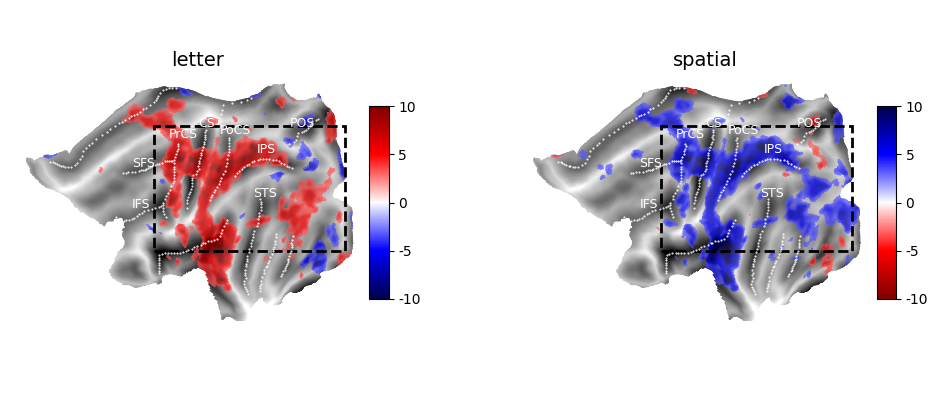

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

for ii, sss in enumerate(['letter','spatial']):
    ax = axs[ii]
    plt.sca(ax)
    
    result = scipy.stats.ttest_1samp(dataset[sss], popmean=0, axis=0)
    thresh = su.convert_alpha_to_tval(alpha=0.01, df=result.df.mean())

    data = np.copy(result.statistic)
    # data = scipy.ndimage.gaussian_filter(data, sigma=0.75)
    data[np.abs(result.statistic)<thresh] = np.nan
    if sss=='letter':
        cmap = cm.seismic
    else:
        cmap = cm.seismic_r
    color = 'white'
    g = surf.plot.plotmap(
        data=data,
        surf='fs32k_L',
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[vmin,vmax],
        borders=border, bordercolor=color, bordersize=1,
        overlay_type='func', render='matplotlib'
    )
    g.text(x=20, y=220, s=sss, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)
        
    rect = patches.Rectangle(
        xy=(-40, -40), width=260, height=170,
        linewidth=2, edgecolor='k', facecolor='none', linestyle='--'
    )
    g.add_patch(rect)
    # xmin = rect.get_x()
    # xmax = xmin + rect.get_width()
    # ymin = rect.get_y()
    # ymax = ymin + rect.get_height()
    # g.set_xlim(xmin,xmax)
    # g.set_ylim(ymin,ymax)

## 3. Overlap t-map

In [25]:
data = []
threshold = np.ones(3)

for ii, sss in enumerate(['letter',None,'spatial']):
    if sss==None:
        data.append(sss)
        continue
    ## set alpha
    stat = scipy.stats.ttest_1samp(dataset[sss], popmean=0, axis=0)
    thresh = su.convert_alpha_to_tval(alpha=0.01, df=stat.df.mean())
    threshold[ii] = thresh

    ## set rgb
    data.append(stat.statistic)

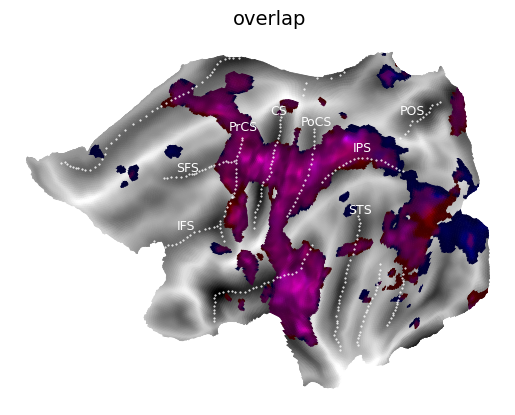

In [26]:
color = 'white'
g = surf.plot.plotmap(
    data=suit.flatmap.map_to_rgb(data=data, threshold=threshold),
    surf='fs32k_%s'%hem,
    colorbar=True,
    borders=border, bordercolor=color, bordersize=1,
    overlay_type='rgb',
)
g.text(x=20, y=220, s='overlap', ha='center', va='center', fontsize=14)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)